## Executive Summary: Predictive Modeling for NBA Player Salaries

This notebook harnesses the power of machine learning to predict NBA player salaries for the 2022-23 season by leveraging both per-game and advanced statistics. The goal of this project is to gain insights into the financial aspects of professional basketball. By applying advanced regression techniques, including feature scaling, feature selection with Lasso Regression and cross-validation, we aim to improve understanding of the relationship between various performance factors and player compensation as well as investigating players who are over and under paid according to the model.

In [105]:
import pandas as pd
import numpy as np

# Load data on player stats and salaries
df = pd.read_csv('/Users/jamiewelsh/Python/NBA_data_analysis/data_files/nba_2022-23_all_stats_with_salary.csv', index_col=0)

# Fill columns with NaN values with zeros
columns_to_fill = ['FT%', '3P%', '2P%', 'eFG%', 'FG%',  '3PAr', 'FTr', 'TOV%', 'TS%']
df[columns_to_fill] = df[columns_to_fill].fillna(0)

# Display first five rows of dataframe
df.head()

,Player Name,Salary,Position,Age,Team,GP,GS,MP,FG,FGA,...,TOV%,USG%,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP
0,Stephen Curry,48070014,PG,34,GSW,56,56,34.7,10.0,20.2,...,12.5,31.0,5.8,2.0,7.8,0.192,7.5,0.1,7.5,4.7
1,John Wall,47345760,PG,32,LAC,34,3,22.2,4.1,9.9,...,17.1,27.0,-0.4,0.7,0.3,0.020,-0.8,-0.4,-1.2,0.1
2,Russell Westbrook,47080179,PG,34,LAL/LAC,73,24,29.1,5.9,13.6,...,18.4,27.7,-0.6,2.6,1.9,0.044,0.3,-0.1,0.2,1.2
3,LeBron James,44474988,PF,38,LAL,55,54,35.5,11.1,22.2,...,11.6,33.3,3.2,2.4,5.6,0.138,5.5,0.6,6.1,4.0
4,Kevin Durant,44119845,PF,34,BRK/PHO,47,47,35.6,10.3,18.3,...,13.4,30.7,4.7,2.1,6.8,0.194,6.0,1.2,7.1,3.9


## Outlier Removal

In the dataset, numerous players participated in a limited number of games, possibly as part of short-term or non-guaranteed contracts such as 10-day contracts. This situation introduces a layer of complexity to the salary prediction task. The primary focus of this project is to project the salaries of players with full NBA contracts, ensuring a more robust and meaningful analysis.

Moreover, players with a minimal number of game appearances may have experienced significant injuries, rendering their salary prediction challenging based solely on their on-court performance. To address this issue and enhance the reliability of our predictions, we have opted to exclude players who participated in fewer than 25 games during the season. This strategic filtering helps refine the dataset by prioritizing players with more substantial game involvement, thereby contributing to a more accurate and relevant salary prediction model.

In [106]:
df = df[df['GP'] >= 25]

## Train/Test Split and Feature Scaling

We perform train/test split to evaluate model performance on unseen data. Feature scaling standardises the range of features, aiding algorithms sensitive to feature magnitudes. It's important to scale features before feature selection to ensure consistent comparison of feature importance across variables with varying scales.

In [107]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Select the various explanatory variables such as PPG APG as features 
X = df[['Player Name','Age','GP', 'GS', 'MP',
       'FG', 'FGA', 'FG%', '3P', '3PA', '3P%', '2P', '2PA', '2P%', 'eFG%',
       'FT', 'FTA', 'FT%', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV',
       'PF', 'PTS', 'PER', 'TS%', '3PAr', 'FTr', 'ORB%',
       'DRB%', 'TRB%', 'AST%', 'STL%', 'BLK%', 'TOV%', 'USG%', 'OWS', 'DWS',
       'WS', 'WS/48', 'OBPM', 'DBPM', 'BPM', 'VORP']]


# Target is salary
y = df['Salary']

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Feature Scaling (Standardization)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.drop('Player Name', axis=1))
X_test_scaled = scaler.transform(X_test.drop('Player Name', axis=1))

# Convert scaled arrays back to pandas DataFrames
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.drop('Player Name', axis=1).columns)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test.drop('Player Name', axis=1).columns)

## Feature Selection

We first identify highly correlated features and remove one feature from any pair where there is a correlation coefficeint of greater than 0.8. Then, we use LASSO regression for additional feature selection, retaining only the features with nonzero coefficients, which are chosen as the selected features.

In [108]:
from sklearn.linear_model import LassoCV

# Calculate the correlation matrix
correlation_matrix = X_train_scaled_df.corr()

# Set the correlation threshold
corr_threshold = 0.8  
correlated_features = set()

# Find the highly correlated features
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > corr_threshold:
            colname_i = correlation_matrix.columns[i]
            colname_j = correlation_matrix.columns[j]
            # Keep one feature and add the other to the set of correlated features to be dropped
            if colname_i not in correlated_features:
                correlated_features.add(colname_j)

# Drop the correlated features
X_filtered = X_train_scaled_df.drop(columns=correlated_features)

# LASSO Regression for additional feature selection
lasso = LassoCV()
lasso.fit(X_filtered, y_train)

# Use SelectFromModel to get selected features based on LASSO coefficients
sfm = SelectFromModel(lasso, prefit=True)
selected_features_lasso = X_filtered.columns[sfm.get_support()]

# Print selected features
print(selected_features_lasso)


Index(['Age', 'GP', '3PA', '3P%', 'FT%', 'TRB', 'STL', 'PF', 'TS%', '3PAr',
       'FTr', 'TRB%', 'STL%', 'TOV%', 'USG%', 'DBPM', 'VORP'],
      dtype='object')


In [109]:
# Get the indices of selected features
selected_feature_indices = [X_train_scaled_df.columns.get_loc(feature) for feature in selected_features_lasso]

# Filter the numpy arrays by the selected features
X_train_scaled_selected = X_train_scaled[:, selected_feature_indices]
X_test_scaled_selected = X_test_scaled[:, selected_feature_indices]


## Model Selection with Cross-Validation

Below, five different models are trained on the training dataset with 5-fold cross validation.

In [110]:
from sklearn.model_selection import cross_val_score
import numpy as np

# Define cross-validation function
def cross_validate_model(model, X, y, cv=5):
    mse_scores = -cross_val_score(model, X, y, cv=cv, scoring='neg_mean_squared_error')
    r2_scores = cross_val_score(model, X, y, cv=cv, scoring='r2')
    return np.mean(mse_scores), np.mean(r2_scores)

# Define and Train Regression Models
models = [
    ('Linear Regression', LinearRegression()),
    ('Decision Tree Regressor', DecisionTreeRegressor(random_state=42)),
    ('Random Forest Regressor', RandomForestRegressor(random_state=42)),
    ('Support Vector Regressor', SVR(kernel='linear')),
    ('Gradient Boosting Regressor', GradientBoostingRegressor(random_state=42))
]

for model_name, model in models:
    # Perform cross-validation
    mse_mean, r2_mean = cross_validate_model(model, X_train_scaled_selected, y_train)
    
    # Print results
    print(f'Model: {model_name}')
    print(f'Mean Squared Error (MSE): {mse_mean:.4e}')  # Use scientific notation formatting
    print(f'R-squared (R2): {r2_mean:.4f}')
    print('---')


Model: Linear Regression
Mean Squared Error (MSE): 4.5087e+13
R-squared (R2): 0.6074
---
Model: Decision Tree Regressor
Mean Squared Error (MSE): 8.7934e+13
R-squared (R2): 0.2395
---
Model: Random Forest Regressor
Mean Squared Error (MSE): 3.9883e+13
R-squared (R2): 0.6538
---
Model: Support Vector Regressor
Mean Squared Error (MSE): 1.3842e+14
R-squared (R2): -0.1851
---
Model: Gradient Boosting Regressor
Mean Squared Error (MSE): 3.9131e+13
R-squared (R2): 0.6631
---


The Gradient Boosting Regressor exhbits the lowest corss-validated MSE and the greatest cross-validated R^2 score. Hence, we will re-train this model on the entire training dataset and evaluate it on the held out dataset.

## Re-training Gradient Boosting Regressor and Evaluating on the Test Dataset

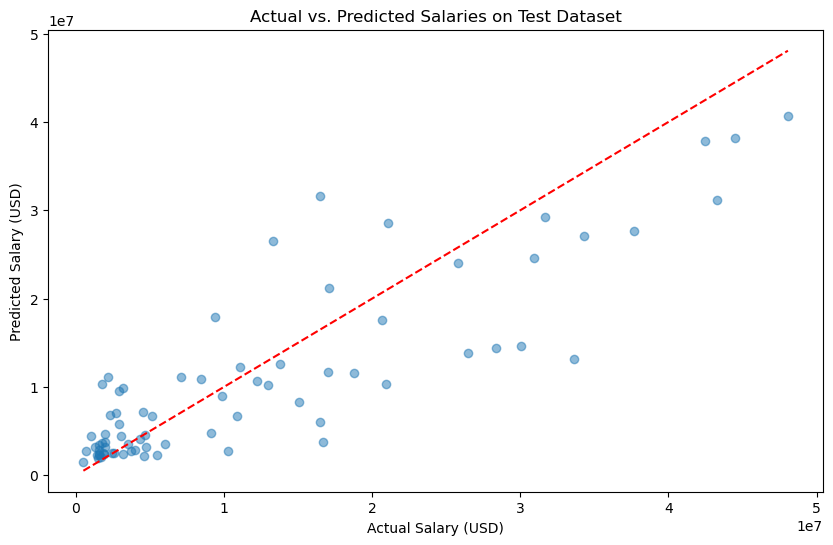

Mean Squared Error (MSE): 4.1267e+13
R-squared (R2): 0.7352


In [111]:
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score


# Retrain the GB Regressor on the full training data
gb_model =  GradientBoostingRegressor(random_state=42)
gb_model.fit(X_train_scaled_selected, y_train)

# Make predictions on the test set
y_pred = gb_model.predict(X_test_scaled_selected)

# Calculate MSE and R2 on the test set
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Get predictions, actual values, and player names for the test set into a dataframe
predictions_df = pd.DataFrame({
    'Player Name': test_df['Player Name'],
    'Actual Salary': y_test,
    'Predicted Salary': y_pred
})

# Plot actual vs. predicted salaries
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.title('Actual vs. Predicted Salaries on Test Dataset')
plt.xlabel('Actual Salary (USD)')
plt.ylabel('Predicted Salary (USD)')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='red')


plt.show()

# Print MSE and R2
print(f'Mean Squared Error (MSE): {mse:.4e}')
print(f'R-squared (R2): {r2:.4f}')


## Visualising Feature Importance

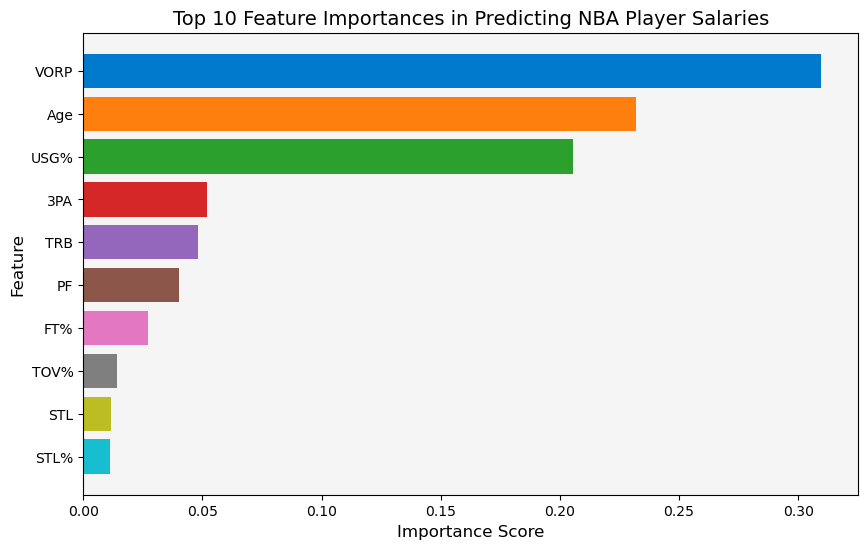

In [112]:
# Get feature importances from the trained Random Forest model
feature_importances = gb_model.feature_importances_

# Create a DataFrame to associate feature names with their importance scores
importance_df = pd.DataFrame({'Feature': X_train_scaled_df[selected_features_lasso].columns, 'Importance': feature_importances})

# Sort the features by importance in descending order
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Set a stylish color palette
colors = ['#007acc', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

# Create an eye-catching horizontal bar chart
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'][:10], importance_df['Importance'][:10], color=colors)
plt.title('Top 10 Feature Importances in Predicting NBA Player Salaries', fontsize=14)
plt.xlabel('Importance Score', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.gca().invert_yaxis()  # Invert the y-axis to show the most important features at the top

# Add a cool background
ax = plt.gca()
ax.set_facecolor('#f5f5f5')

plt.show()



Interestingly, points per game was removed in the feature selection stage and is therefore superfluous in relation to our feature set. Unsurprisingly the popular advanced metric VORP ranks very highly. As does age which makes perfect sense as players are eligible for higher contracts the after their rookie deals and you need to have been in the league for 8/9 years for a supermax contract.

In [113]:
# Calculate absolute and percentage difference between actual salary and predicted salary
predictions_df['Absolute Difference'] = predictions_df['Actual Salary'] - predictions_df['Predicted Salary']
predictions_df['Percentage Difference'] = (predictions_df['Absolute Difference'] / predictions_df['Predicted Salary']) * 100

# Convert 'Actual Salary' column to numeric format
predictions_df['Actual Salary'] = pd.to_numeric(predictions_df['Actual Salary'], errors='coerce')

# Apply scientific notation formatting
predictions_df['Actual Salary'] = predictions_df['Actual Salary'].apply(lambda x: f'{x:.2e}')
predictions_df['Predicted Salary'] = predictions_df['Predicted Salary'].apply(lambda x: f'{x:.2e}')
predictions_df['Absolute Difference'] = predictions_df['Absolute Difference'].apply(lambda x: f'{x:.2e}')

predictions_df.head()

,Player Name,Actual Salary,Predicted Salary,Absolute Difference,Percentage Difference
203,Jalen Smith,4.67e+06,4.52e+06,1.50e+05,3.328906
34,Shai Gilgeous-Alexander,3.09e+07,2.46e+07,6.36e+06,25.916339
15,Jimmy Butler,3.77e+07,2.77e+07,9.94e+06,35.886439
331,Jalen McDaniels,1.93e+06,2.37e+06,-4.41e+05,-18.591245
58,Aaron Gordon,2.07e+07,1.75e+07,3.16e+06,18.039419


In [114]:
predictions_df.sort_values(by='Percentage Difference', ascending=False).head(5)

,Player Name,Actual Salary,Predicted Salary,Absolute Difference,Percentage Difference
78,Collin Sexton,1.67e+07,3.75e+06,1.30e+07,345.849787
118,Mo Bamba,1.03e+07,2.70e+06,7.60e+06,281.422831
79,Markelle Fultz,1.65e+07,6.05e+06,1.05e+07,172.919497
26,Andrew Wiggins,3.36e+07,1.31e+07,2.05e+07,155.885370
186,Dyson Daniels,5.51e+06,2.31e+06,3.20e+06,138.787279


We see that Mo Bamba and Collin Sexton's relatively high salaries exceed signifcantly their predicted salaries based on their output last season. Furthermore, the model also implies significant overvaluation in the salaries of Markelle Fultz and Andrew Wiggins. Andrew Wiggins had a disappointing season in 2022-23 coming off several good playoff performances on the way to the Warriors NBA Championship in 2022. Hence, due to his drop in performance, it seems reasonable that the model predicts his salary to be predicted at around $13.1 million as opposed to its true value of $33.6 million.

In [115]:
predictions_df.sort_values(by='Percentage Difference', ascending=True).head(5)

,Player Name,Actual Salary,Predicted Salary,Absolute Difference,Percentage Difference
349,Nick Richards,1.78e+06,1.04e+07,-8.58e+06,-82.801032
302,Jaden McDaniels,2.16e+06,1.11e+07,-8.94e+06,-80.527558
385,Jaden Hardy,1.02e+06,4.43e+06,-3.41e+06,-77.032237
400,Anthony Lamb,6.95e+05,2.69e+06,-1.99e+06,-74.127595
265,Taj Gibson,2.91e+06,9.48e+06,-6.58e+06,-69.355030


Jaden Hardy and Jaden McDaniels appear to be on very team-friendly deals according to the model. McDaniels has emerged as one of the better perimeter defenders in the league and despite only scoring 12.1 PPG, he averaged over 50% from the field and almost 40% from three-point range in the 2022-23 season on a team with offensive weapons like Anthony Edwards and Karl Anthony Towns. I'm sure that most Minnesota fans would agree that his $2.16 million salary for the 2022-23 season was amongst the biggest bargains in the NBA.